# Exploratory Data Analysis EDA for Toxic Comment Classification

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import re
import string
from collections import Counter
import nltk
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
# Set plot style
plt.style.use('ggplot')
sns.set(style="darkgrid")

### Load the Data

In [3]:
# Load the dataset 
df = pd.read_csv('../train.csv')

# Display the first rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Data Shape and Missing Values

In [5]:
# Check data shape (row, columns)
print(f"Dataset shape: {df.shape}")

# Check for missing values
print(f"Missing values per column: ")
print (df.isnull().sum())

Dataset shape: (159571, 8)
Missing values per column: 
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


### There is no duplicates in the data

In [8]:
df.duplicated().sum()

0

### Analyzing Label Distribution and Class Imbalance Check

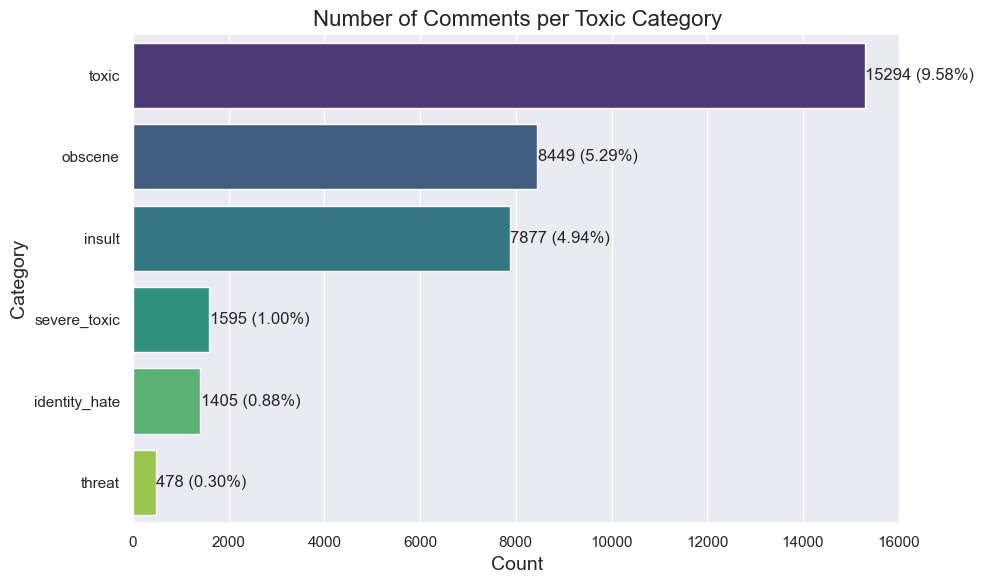

In [ ]:
# Calculate the count of comments per class
label_counts = df.iloc[:, 2:].sum().sort_values(ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=label_counts.values, y=label_counts.index, palette="viridis")
plt.title('Number of Comments per Toxic Category', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Category', fontsize=14)

# Add value labels to the bars
for i, count in enumerate(label_counts.values):
    ax.text(count + 10, i, f"{count} ({count/df.shape[0]*100:.2f}%)", va='center')

plt.tight_layout()
plt.show()

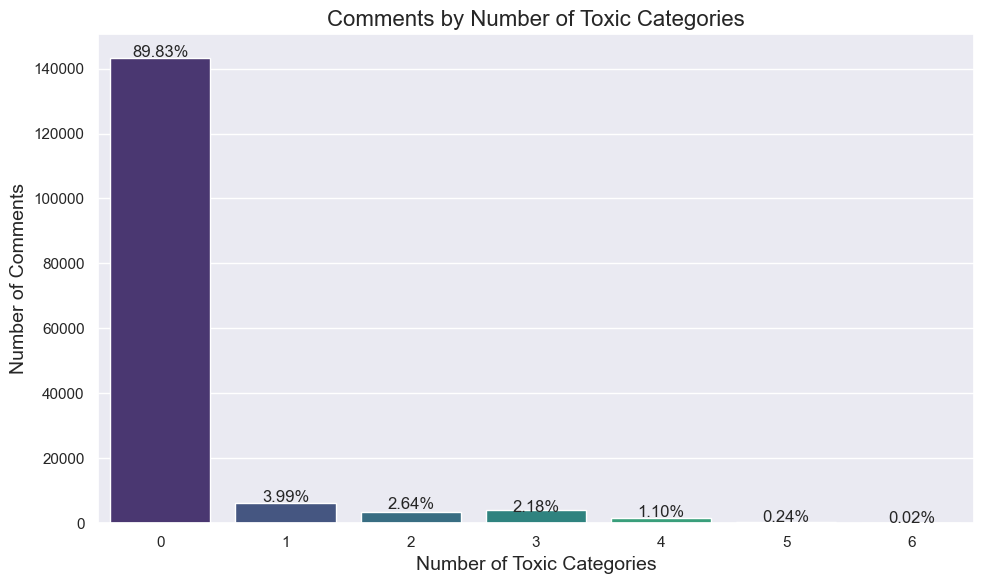

In [25]:
# Calculate how many comments have multiple toxic labels
label_counts = df.iloc[:, 2:].sum(axis=1).value_counts()
 
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title('Comments by Number of Toxic Categories', fontsize=16)
plt.xlabel('Number of Toxic Categories', fontsize=14)
plt.ylabel('Number of Comments', fontsize=14)
plt.xticks(range(len(label_counts)))
plt.tight_layout()

# Add percentage labels
total = sum(label_counts.values)
for i, count in enumerate(label_counts.values):
    plt.text(i, count + 100, f"{count/total*100:.2f}%", ha='center')

plt.show()

Non-toxic comments: 143346 (89.83%)
Toxic comments: 16225 (10.17%)


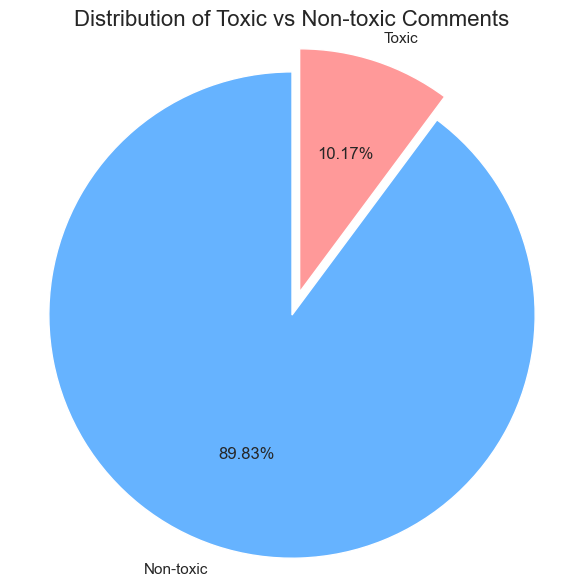

In [7]:
# How many comments are non-toxic (all zeros)?
non_toxic_count = (df.iloc[:, 2:].sum(axis=1) == 0).sum()
toxic_count = df.shape[0] - non_toxic_count
print(f"Non-toxic comments: {non_toxic_count} ({non_toxic_count/df.shape[0]*100:.2f}%)")
print(f"Toxic comments: {toxic_count} ({toxic_count/df.shape[0]*100:.2f}%)")

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie([non_toxic_count, toxic_count], 
        labels=['Non-toxic', 'Toxic'], 
        autopct='%1.2f%%',
        colors=['#66b3ff', '#ff9999'],
        startangle=90,
        explode=(0.1, 0))
plt.title('Distribution of Toxic vs Non-toxic Comments', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

### Label Correlation

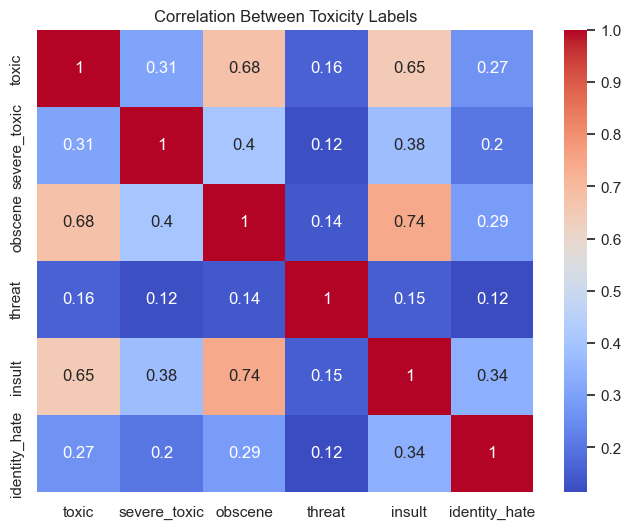

In [8]:
# Calculate correlation between labels
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_corr = df[labels].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(label_corr, annot=True, cmap='coolwarm')
plt.title("Correlation Between Toxicity Labels")
plt.show()

### Analyzing Text Characteristics

In [33]:
# Add text length as a new feature
df['text_length'] = df['comment_text'].apply(len)
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

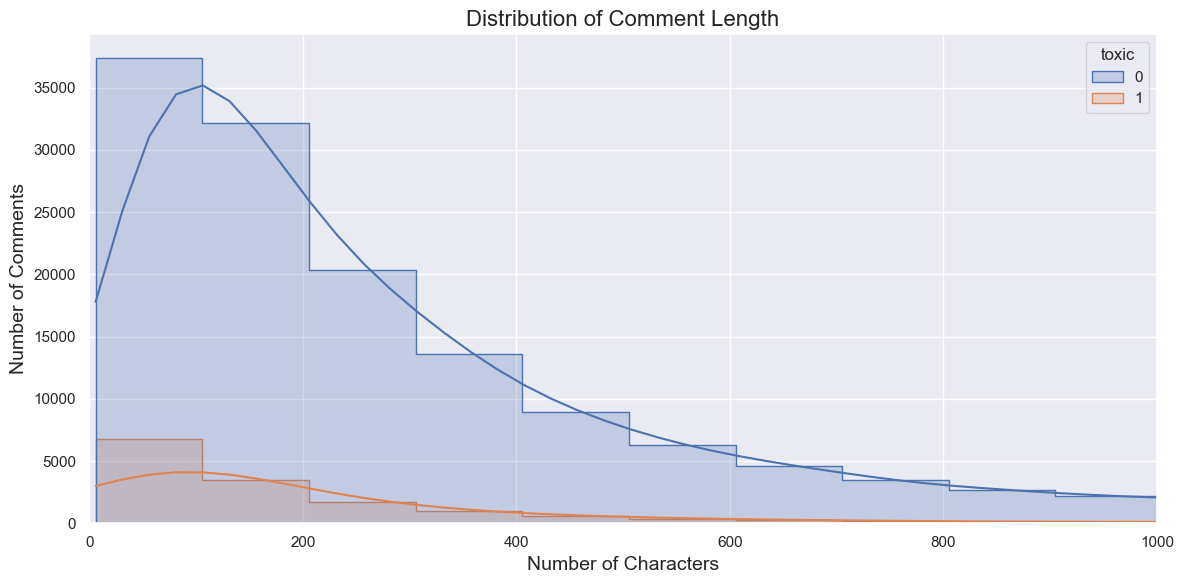

In [32]:
# Distribution of text length
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='toxic', bins=50, kde=True, element="step")
plt.title('Distribution of Comment Length', fontsize=16)
plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Number of Comments', fontsize=14)
plt.xlim(0, 1000)  # Limit x-axis for better visualization
# plt.legend(['Non-toxic', 'Toxic'])
plt.tight_layout()
plt.show()

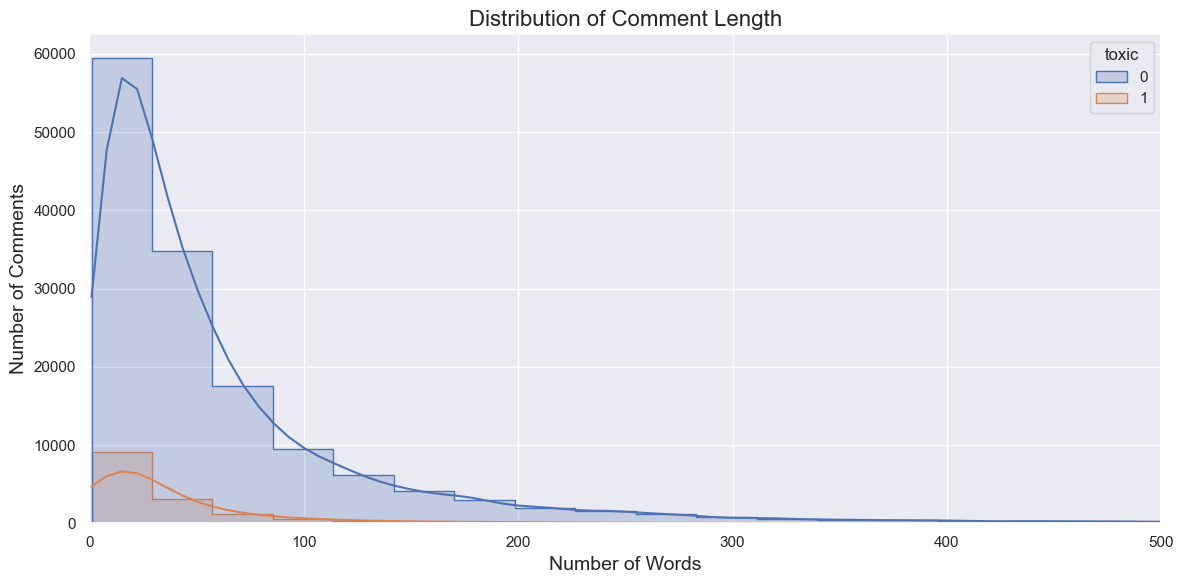

In [36]:
# Distribution of text length
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='toxic', bins=50, kde=True, element="step")
plt.title('Distribution of Comment Length', fontsize=16)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Number of Comments', fontsize=14)
plt.xlim(0, 500)  # Limit x-axis for better visualization
# plt.legend(['Non-toxic', 'Toxic'])
plt.tight_layout()
plt.show()

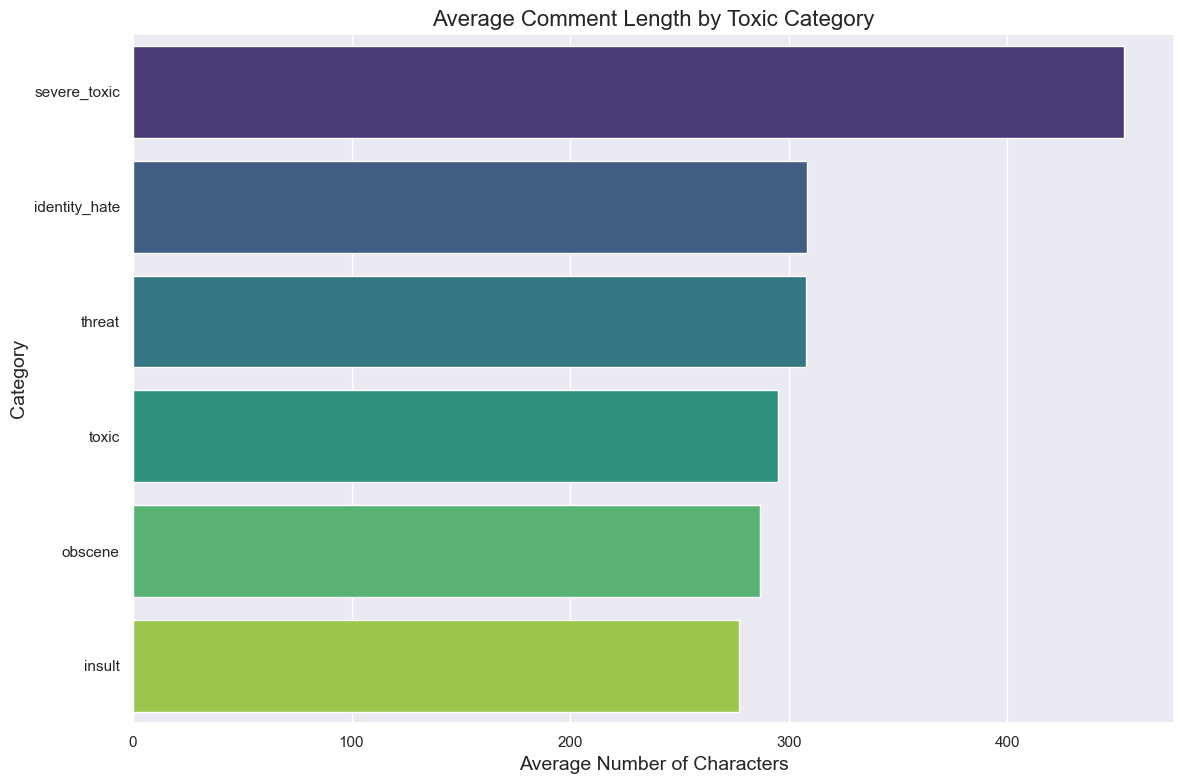

In [40]:
# Compare text length across all toxic categories
plt.figure(figsize=(12, 8))
label_length_data = []

for label in df.iloc[:, 2:8].columns:
    mean_length = df[df[label] == 1]['text_length'].mean()
    label_length_data.append((label, mean_length))

label_length_df = pd.DataFrame(label_length_data, columns=['label', 'mean_length'])
label_length_df = label_length_df.sort_values('mean_length', ascending=False)

sns.barplot(x='mean_length', y='label', data=label_length_df, palette='viridis')
plt.title('Average Comment Length by Toxic Category', fontsize=16)
plt.xlabel('Average Number of Characters', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.tight_layout()
plt.show()

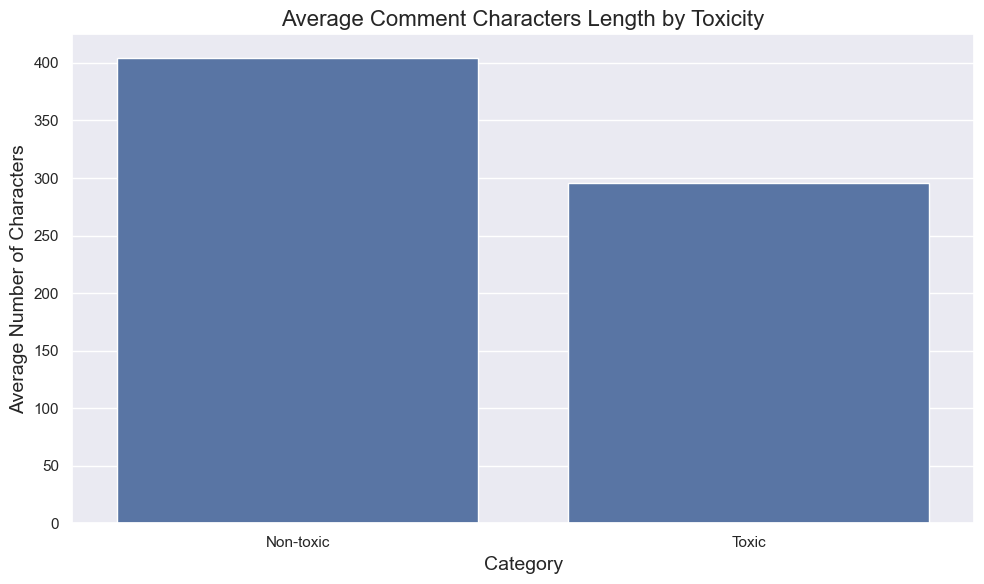

In [39]:
# Calculate average text length by category
plt.figure(figsize=(10, 6))
word_length_by_category = df.groupby('toxic')['text_length'].mean()
sns.barplot(x=['Non-toxic', 'Toxic'], y=word_length_by_category.values)
plt.title('Average Comment Characters Length by Toxicity', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Average Number of Characters', fontsize=14)
plt.tight_layout()
plt.show()

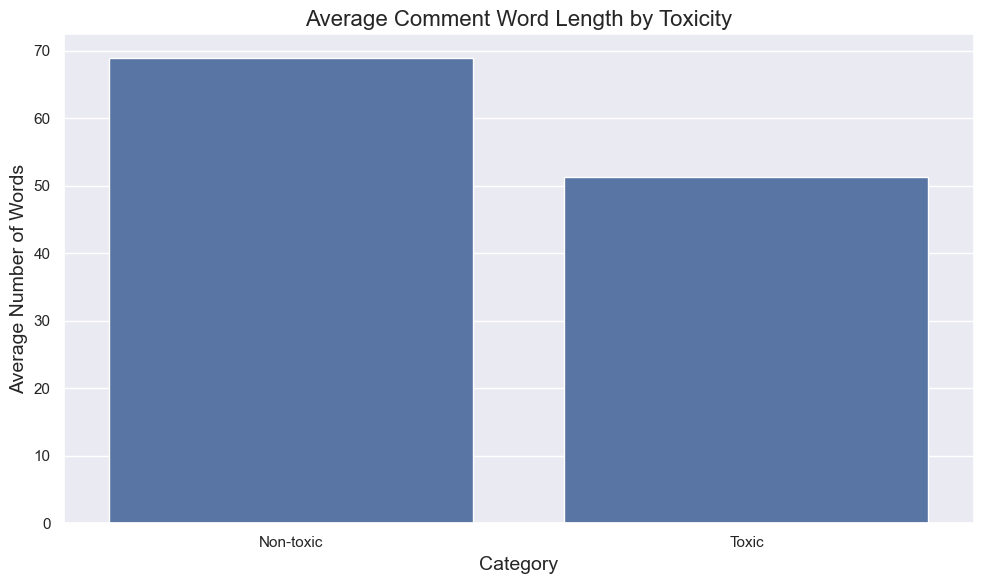

In [38]:
# Calculate average text length by category
plt.figure(figsize=(10, 6))
word_length_by_category = df.groupby('toxic')['word_count'].mean()
sns.barplot(x=['Non-toxic', 'Toxic'], y=word_length_by_category.values)
plt.title('Average Comment Word Length by Toxicity', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Average Number of Words', fontsize=14)
plt.tight_layout()
plt.show()

### Word Frequency Analysis
#### analyze the most common words in toxic and non-toxic comments:

In [ ]:
def get_most_word_frequency(text_series, stopwords_file='stopwords_english.txt'):
    
    # Load stopwords from file
    try:
        # Try to load the stopwords file
        with open(stopwords_file, 'r', encoding='utf-8') as f:
            stop_words = set(line.strip() for line in f if line.strip())
    except FileNotFoundError:
        # If file doesn't exist, create it with basic stopwords
        print(f"Stopwords file not found. Creating a new one at {stopwords_file}")
        # Creating a minimal set of stopwords
        stop_words = {'a', 'an', 'the', 'and', 'or', 'but', 'if', 'because', 'as', 'what', 
                     'which', 'this', 'that', 'these', 'those', 'then', 'just', 'so', 'than', 
                     'when', 'where', 'how', 'why', 'i', 'me', 'my', 'myself', 'we', 'our', 
                     'you', 'your', 'he', 'she', 'it', 'its', 'they', 'them', 'their'}
        
        # Save the basic stopwords to file for future use
        with open(stopwords_file, 'w', encoding='utf-8') as f:
            for word in sorted(stop_words):
                f.write(word + '\n')
    
    # Combine all comments
    text = ' '.join(text_series.astype(str))
    
    # Remove URLs, mentions, punctuation and convert to lowercase
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = text.lower()
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    
    # Simple tokenization with regex
    tokens = re.findall(r'\b\w+\b', text)
    
    # Filter out stopwords and short words
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Also return the most common words
    word_freq = Counter(filtered_tokens)
    return pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Count'])


# 2. Now generate the wordclouds
toxic_comments = df[df['toxic'] == 1]['comment_text']
non_toxic_comments = df[df['toxic'] == 0]['comment_text']

# Generate wordclouds for each toxic category
for label in df.iloc[:, 2:8].columns:
    if df[label].sum() > 0:  # Check if there are comments in this category
        category_comments = df[df[label] == 1]['comment_text']
        category_words = get_most_word_frequency(category_comments)
        print(f"Most Common Words in {label.replace("_", " ").title()} Comments")
        display(category_words)


Most Common Words in Toxic Comments


,Word,Count
0,fuck,9933
1,shit,3621
2,like,3512
3,wikipedia,3433
4,nigger,3299
5,fucking,3289
6,suck,3235
7,ass,2940
8,hate,2631
9,get,2300


Most Common Words in Severe Toxic Comments


,Word,Count
0,fuck,7303
1,suck,2535
2,ass,2114
3,shit,1884
4,faggot,1571
5,fucking,1456
6,die,1156
7,bitch,1113
8,nigger,1012
9,sucks,961


Most Common Words in Obscene Comments


,Word,Count
0,fuck,9861
1,shit,3212
2,fucking,3192
3,suck,3021
4,ass,2847
5,nigger,2726
6,bitch,1795
7,wikipedia,1708
8,like,1541
9,cunt,1531


Most Common Words in Threat Comments


,Word,Count
0,die,1168
1,ass,772
2,kill,504
3,going,294
4,block,170
5,must,167
6,fuck,166
7,jim,158
8,wales,157
9,supertr0ll,151


Most Common Words in Insult Comments


,Word,Count
0,fuck,7926
1,fucking,2799
2,suck,2792
3,nigger,2780
4,ass,2212
5,fat,1926
6,faggot,1867
7,bitch,1733
8,shit,1689
9,like,1565


Most Common Words in Identity Hate Comments


,Word,Count
0,nigger,2969
1,fat,1322
2,jew,1314
3,gay,918
4,fuck,880
5,die,879
6,faggot,742
7,fucking,518
8,huge,430
9,suck,427


### Punctuation and Special Character Analysis

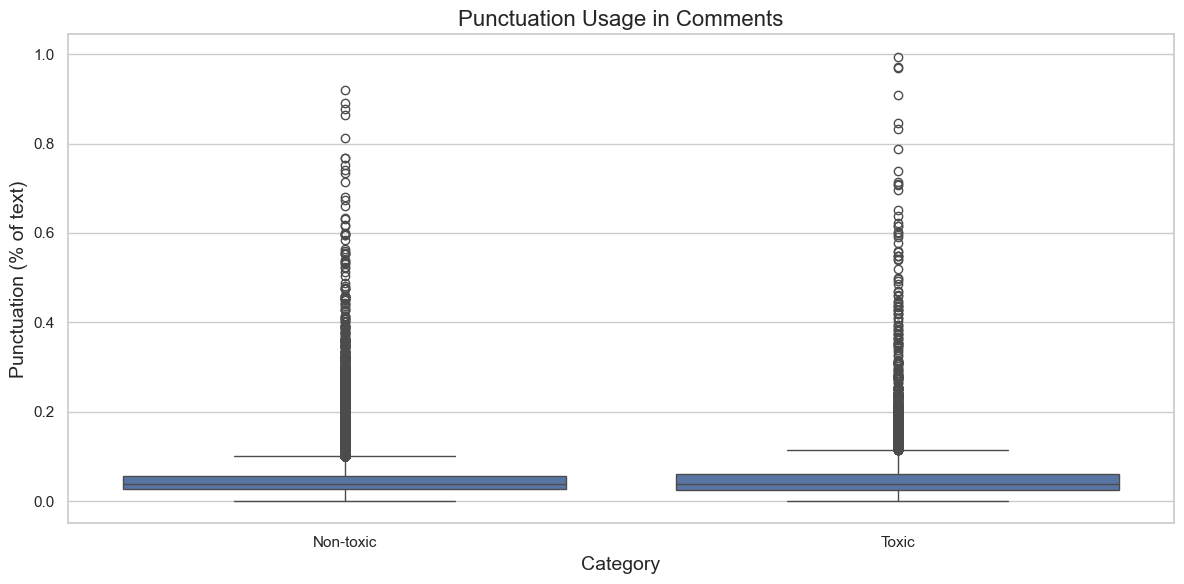

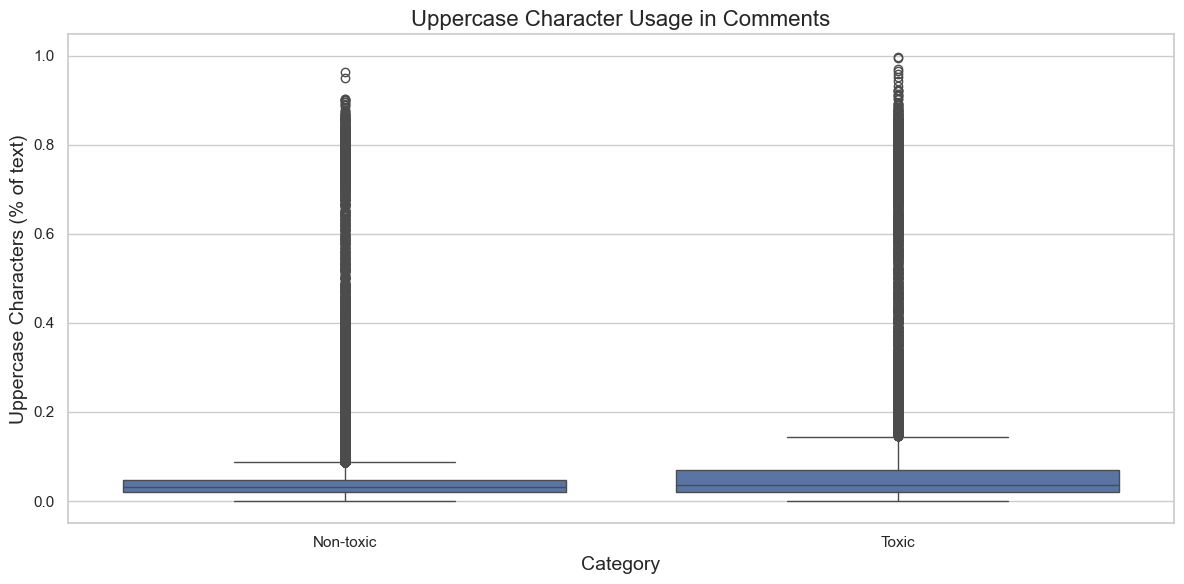

In [20]:
def count_punctuation(text):
    count = sum([1 for char in str(text) if char in string.punctuation])
    return count / len(str(text)) if len(str(text)) > 0 else 0

df['punct_percent'] = df['comment_text'].apply(count_punctuation)

# Compare punctuation usage across toxic and non-toxic comments
plt.figure(figsize=(12, 6))
sns.boxplot(x='toxic', y='punct_percent', data=df)
plt.title('Punctuation Usage in Comments', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Punctuation (% of text)', fontsize=14)
plt.xticks([0, 1], ['Non-toxic', 'Toxic'])
plt.tight_layout()
plt.show()

# Function to count uppercase characters
def count_uppercase(text):
    count = sum(1 for c in str(text) if c.isupper())
    return count / len(str(text)) if len(str(text)) > 0 else 0

df['uppercase_percent'] = df['comment_text'].apply(count_uppercase)

# Compare uppercase usage across toxic and non-toxic comments
plt.figure(figsize=(12, 6))
sns.boxplot(x='toxic', y='uppercase_percent', data=df)
plt.title('Uppercase Character Usage in Comments', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Uppercase Characters (% of text)', fontsize=14)
plt.xticks([0, 1], ['Non-toxic', 'Toxic'])
plt.tight_layout()
plt.show()

### Analyzing Toxic Language Patterns

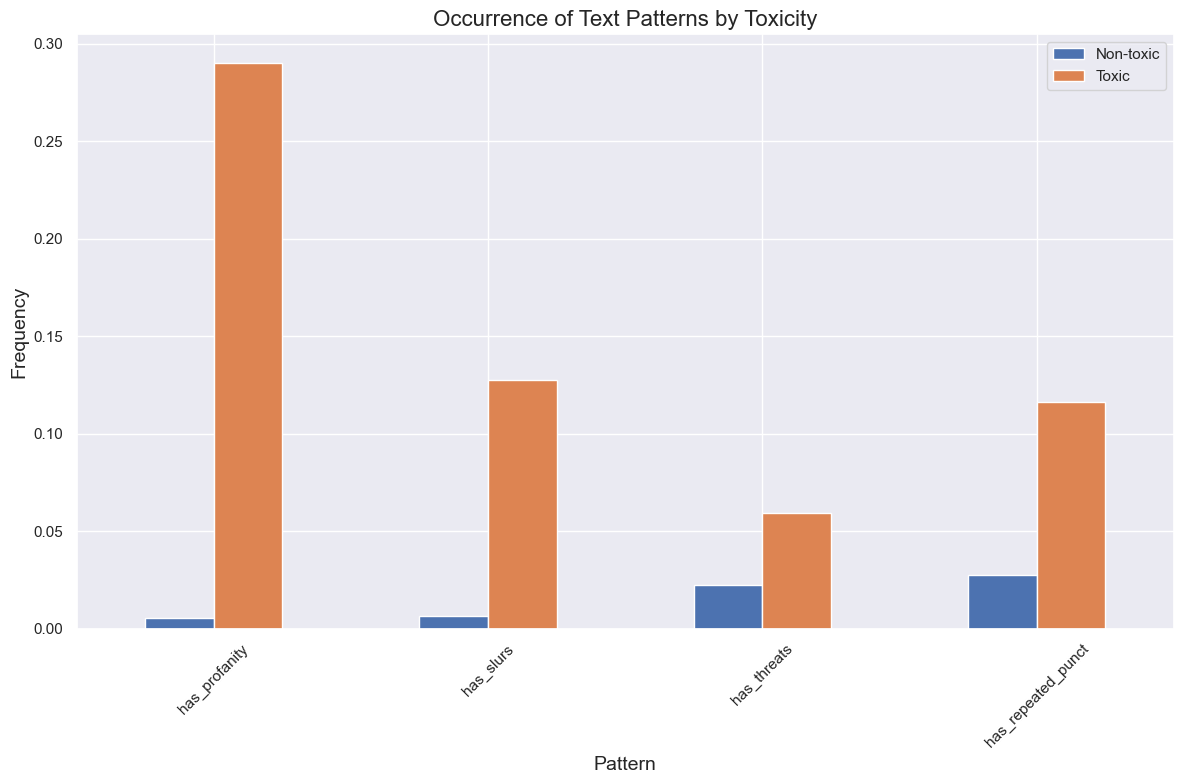

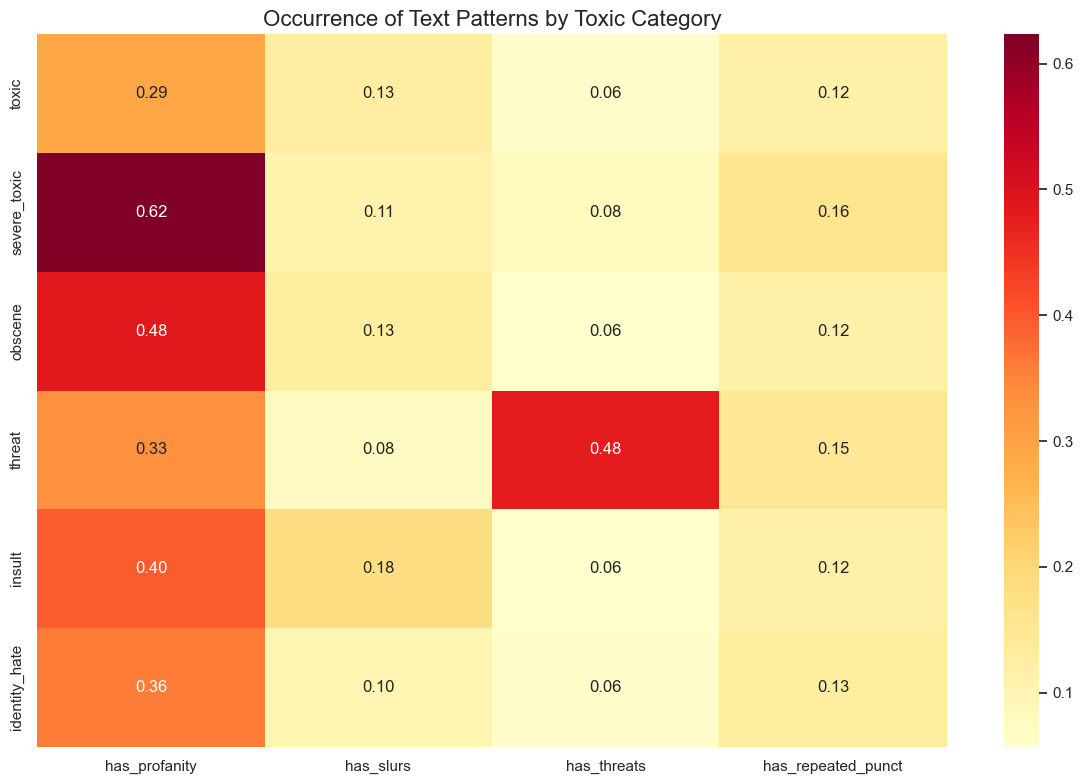

In [ ]:
# Function to detect common toxic patterns
def contains_pattern(text, pattern):
    return 1 if re.search(pattern, str(text).lower()) else 0

# Check for common patterns in toxic comments
patterns = {
    'profanity': r'\b(fuck|shit|damn|ass|bitch)\b',
    'slurs': r'\b(idiot|stupid|dumb|moron|retard)\b',
    'threats': r'\b(kill|die|attack|threat|hurt)\b',
    'repeated_punct': r'[!?]{2,}',  # 2 or more consecutive exclamation or question marks
}

# Add pattern features
for pattern_name, pattern in patterns.items():
    df[f'has_{pattern_name}'] = df['comment_text'].apply(lambda x: contains_pattern(x, pattern))

# Create a grouped bar chart for pattern occurrence by toxicity
pattern_cols = [col for col in df.columns if 'has_' in col]
pattern_means = df.groupby('toxic')[pattern_cols].mean()

plt.figure(figsize=(12, 8))
pattern_means.T.plot(kind='bar', ax=plt.gca())
plt.title('Occurrence of Text Patterns by Toxicity', fontsize=16)
plt.xlabel('Pattern', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.legend(['Non-toxic', 'Toxic'])
plt.tight_layout()
plt.show()

# Create a heatmap showing pattern occurrence across toxic categories
toxic_pattern_means = pd.DataFrame()
for label in df.iloc[:, 2:8].columns:
    toxic_pattern_means[label] = df[df[label] == 1][pattern_cols].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(toxic_pattern_means.T, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Occurrence of Text Patterns by Toxic Category', fontsize=16)
plt.tight_layout()
plt.show()